# Project CodeNet Program Classification with a TBCNN

This notebook shows an application of a TBCNN for classifying programs by functionality. In this experiment we use Python source code from Project CodeNet and predict their problem_id.

Structure of this notebook:
1. Creation of a derived dataset from Project CodeNet
2. Training of a TBCNN on this dataset
3. Visualizations of the Convolutional Layer of the Model using GraphViz
4. Analysis of some interesting findings

In [1]:
%load_ext autoreload
%autoreload 2

## Derived Dataset
The derived dataset contains only source code from submissions with status 'Accepted' and programs written in Python 3.4.3. This constraint allows us to parse the code with the built-in Python-module 'ast'.

First, we create an in-memory representation of the CodeNet dataset to retrieve the metadata of all submissions.

In [2]:
from dataset.CodeNet import CodeNet
code_net = CodeNet(location=r"C:\Users\sebas\Documents\Masterarbeit\Project_CodeNet")

In [3]:
submission_metadata = code_net.get_submission_metadata()
submission_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13916868 entries, 0 to 1088
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   submission_id      string
 1   problem_id         string
 2   user_id            string
 3   date               Int64 
 4   language           string
 5   original_language  string
 6   filename_ext       string
 7   status             string
 8   cpu_time           Int64 
 9   memory             Int64 
 10  code_size          Int64 
 11  accuracy           string
dtypes: Int64(4), string(8)
memory usage: 1.4 GB


pandas Dataframes allow us to query and recombine dataframes to construct the derived dataset.

In [4]:
accepted_python3_submissions = submission_metadata.query("original_language == 'Python (3.4.3)' and status == 'Accepted'")

We further use only submissions with more than 2500 submissions, so we have enough data to train on.

In [5]:
python3_submissions_count = accepted_python3_submissions.groupby(["problem_id", "status"]).size().reset_index(name="count").sort_values("count", ascending=False).query("count > 2500")

By merging these two dataframes we get the final derived data we want.

In [6]:
derived_dataset = accepted_python3_submissions.merge(python3_submissions_count, on="problem_id").drop(columns=["status_y"]).rename(columns={"status_x": "status"})

Finally, we use an instance of `ProblemIdClassificationDataset` to manage the dataset on disk. This class offers functionality to create training-, validation- and test-directory with the specified number of samples for each problem. All samples are randomly sampled from the `derived_dataset`

In [7]:
from dataset.ProblemIdClassificationDataset import ProblemIdClassificationDataset

classification_dataset = ProblemIdClassificationDataset(r"C:\Users\sebas\Documents\Masterarbeit\datasets\tbcnn_py3_2500",
                                                 derived_dataset,
                                                 code_net,
                                                 n_train_per_problem=600,
                                                 n_val_per_problem=100,
                                                 n_test_per_problem=300)

The `create_or_load`-method creates an in-memory representation of the classification-dataset or loads it if it already exists in the file system. More specifically, following steps happen during creation:
1. For each `problem_id` in the `derived_dataset` 1000 submissions are sampled (see parameter of Ctor in previous cell).
2. The 1000 samples are split up into train-, validation- and test-partitions according to the parameter in the previous cell. These partitions are represented by dataframes which are serialized with `pickle` for later loading.
3. Each source file is parsed with the `ast` module and a simpler tree in JSON format is created and placed in its respective directory (train, val or test)
4. All encountered AST node types are collected in a map (str->int) and serialized (node_map).
5. All encountered problem_ids (classification labels) are collected and serialized

In [8]:
classification_dataset.create_or_load()

## TBCNN

### Model Creation

In [63]:
from keras.metrics import Precision, Recall
import tensorflow as tf
from classifier.Tbcnn import Tbcnn
node_map = classification_dataset.get_node_map()
labels = classification_dataset.get_labels()
model = Tbcnn(feature_size=len(node_map), conv_output_size=100, num_classes=len(labels))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam',
              metrics = [tf.keras.metrics.CategoricalAccuracy(), Precision(), Recall()])

### Model Training

In [64]:
from generators.FileStreamDataGenerator import FileStreamDataGenerator

train_files = classification_dataset.get_train_files()
val_files = classification_dataset.get_val_files()
training_generator = FileStreamDataGenerator(train_files, labels, node_map, batch_size=1, shuffle=True)
validation_generator = FileStreamDataGenerator(val_files, labels, node_map, batch_size=1, shuffle=False)
model.fit(training_generator, validation_data=validation_generator, epochs=1)

75600/75600 [==============================] - 163s 2ms/step - loss: 0.6167 - categorical_accuracy: 0.8523 - precision_3: 0.9461 - recall_3: 0.7820 - val_loss: 0.2871 - val_categorical_accuracy: 0.9190 - val_precision_3: 0.9484 - val_recall_3: 0.8981


### Model Evaluation

Next, we evaluate the model on our testset and collect the predicted lables (y_hat).

In [65]:
test_files = classification_dataset.get_test_files()
test_generator = FileStreamDataGenerator(test_files, labels, node_map, batch_size=1, shuffle=False)
y_hat = model.predict(test_generator)
metrics = model.evaluate(test_generator)

37800/37800 [==============================] - 63s 2ms/step - loss: 0.2821 - categorical_accuracy: 0.9198 - precision_3: 0.9505 - recall_3: 0.8998


In [66]:
from numpy import argmax
labels = list(test_generator.get_label_lookup().keys())
expected_labels = []
predicted_labels = []
for i in range(len(test_generator)):
    _, y = test_generator[i]
    expected_label = labels[argmax(y)]
    predicted_label = labels[argmax(y_hat[i])]
    expected_labels.append(expected_label)
    predicted_labels.append(predicted_label)

A confusion matrix allows us to visualize and analyse the output of the model. As the matrix is big (126 x 126) it is best to open it in a separate window.

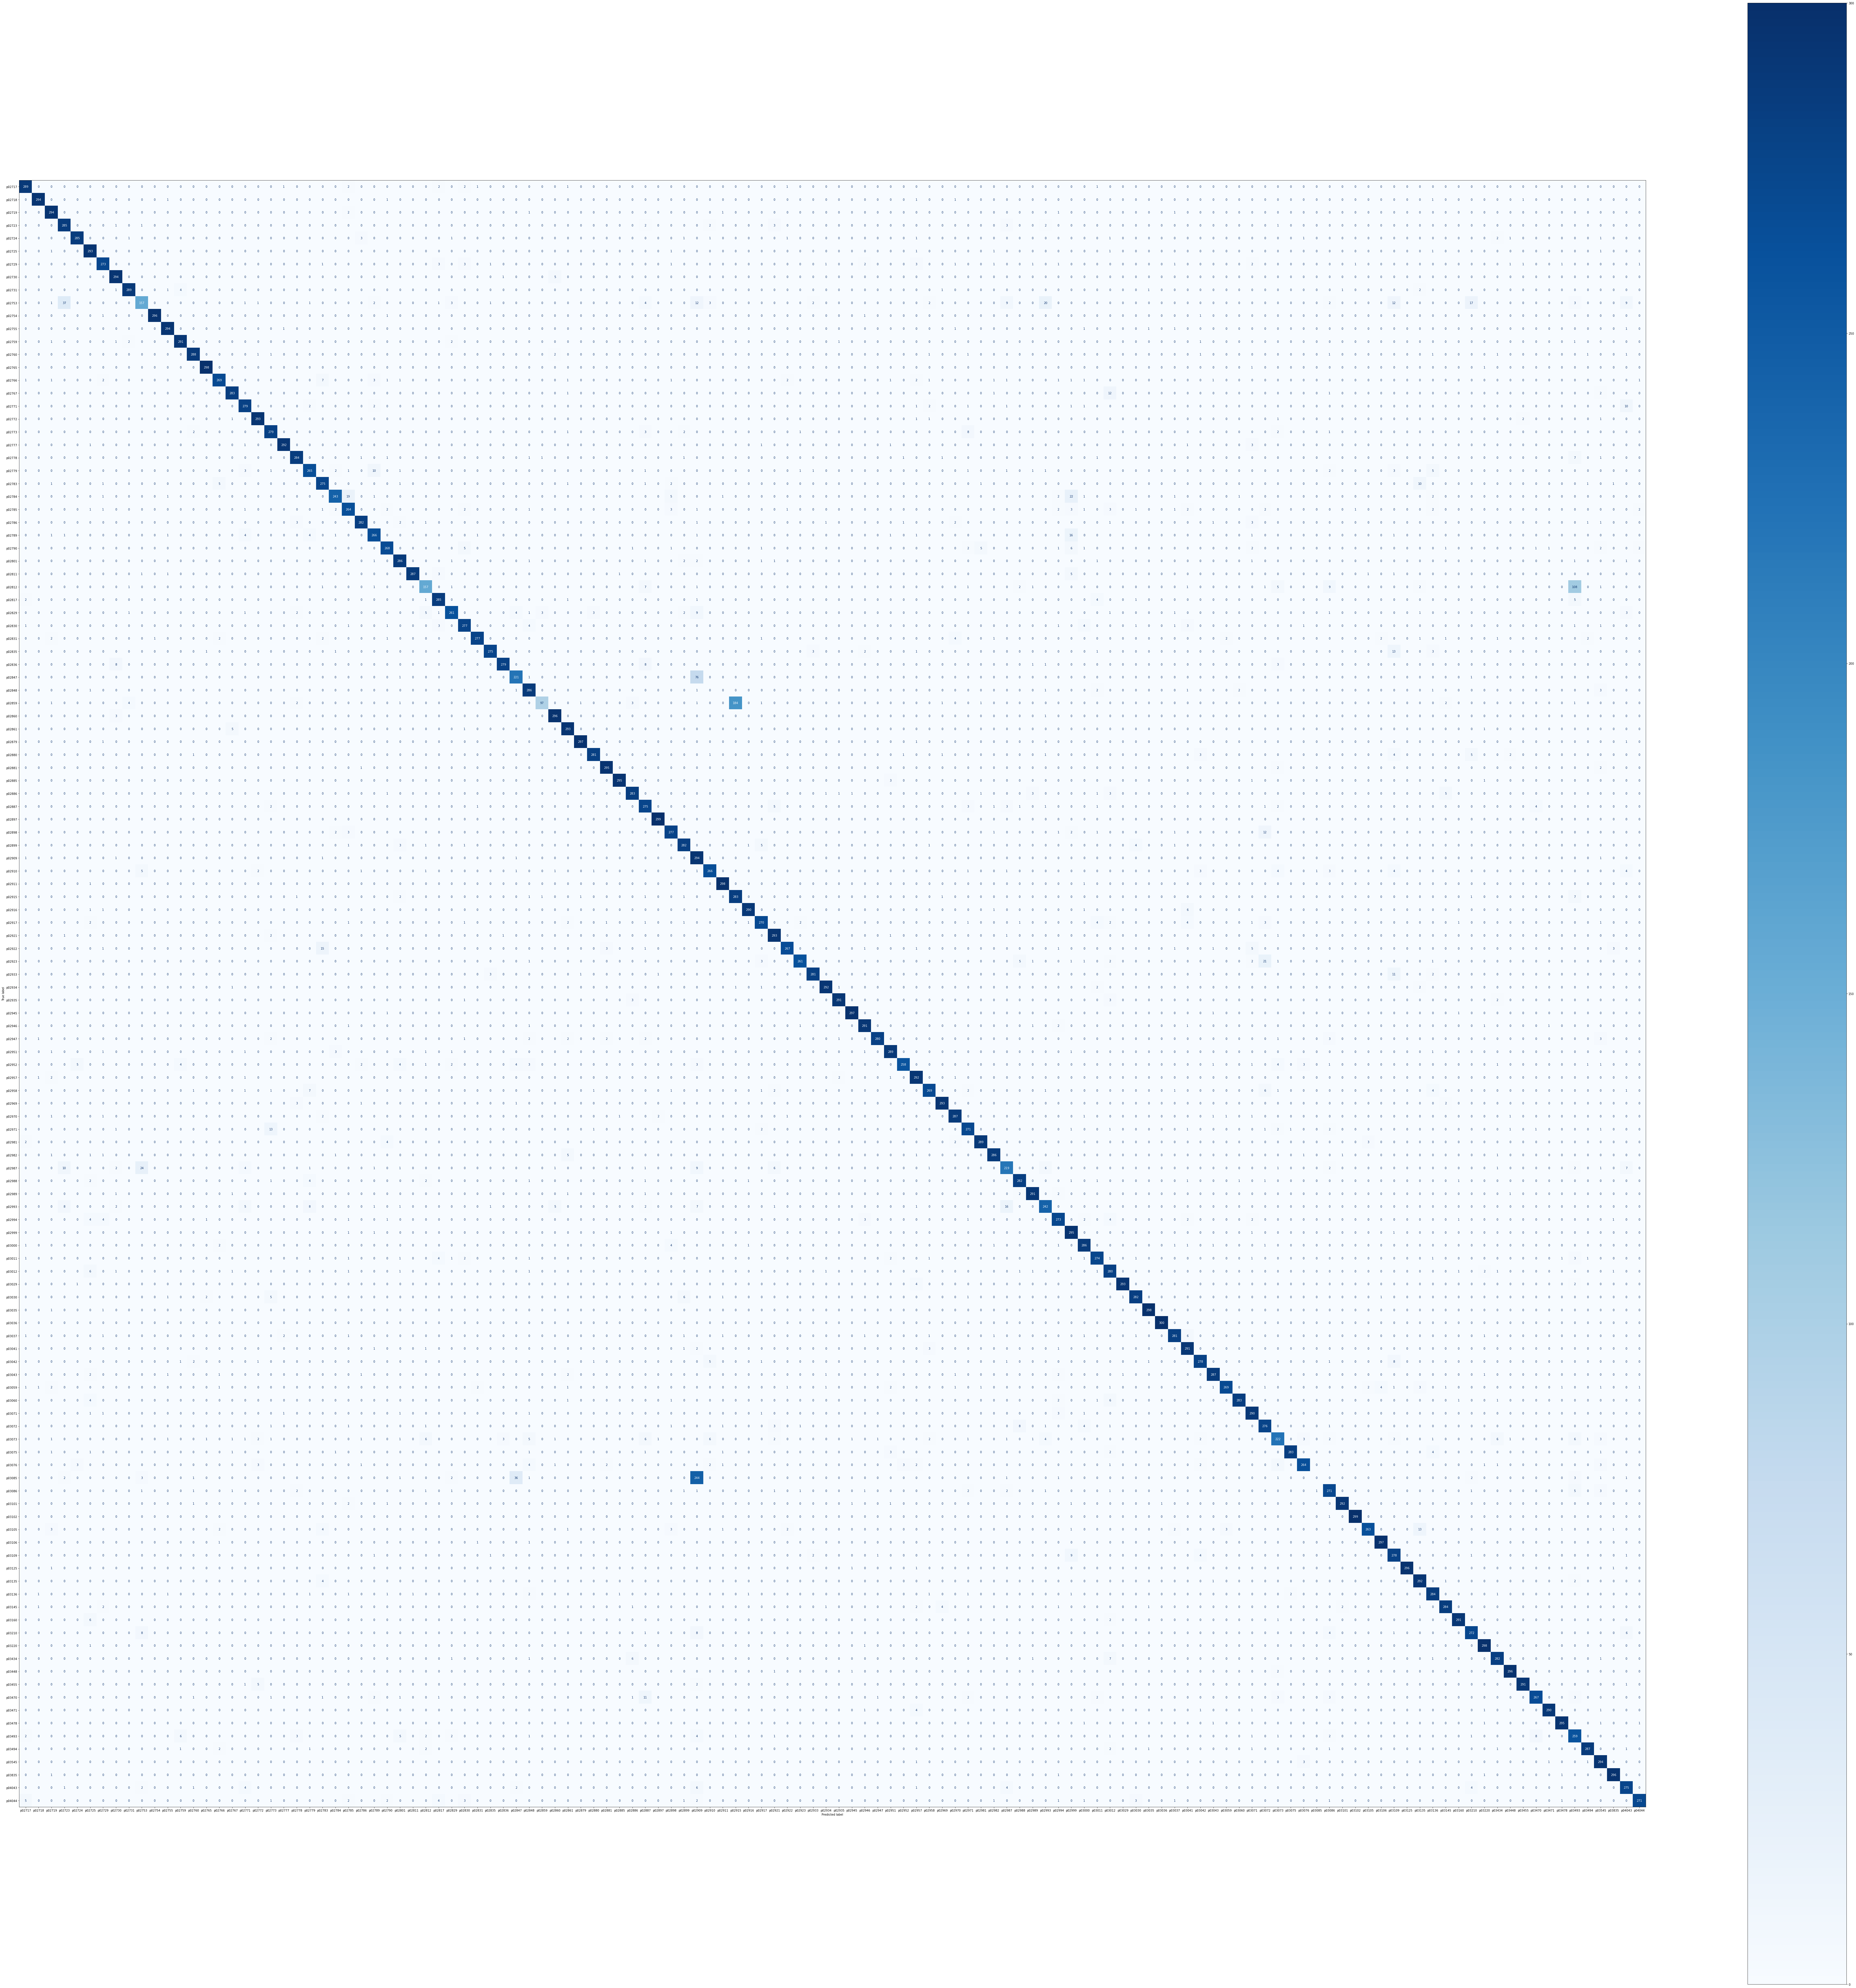

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(126, 126))
cm = confusion_matrix(expected_labels, predicted_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

We can see that, most problems are predicted correctly. Please find a more in-depth analysis in the last section of this notebook.

Additionaly, we create a classification report with common metrics like precision, recall and f1-score.

In [68]:
from sklearn.metrics import classification_report

print(classification_report(expected_labels, predicted_labels, labels=labels))

              precision    recall  f1-score   support

      p02717       0.94      0.96      0.95       300
      p02718       0.98      0.98      0.98       300
      p02719       0.92      0.98      0.95       300
      p02723       0.83      0.95      0.88       300
      p02724       0.97      0.95      0.96       300
      p02725       0.89      0.98      0.93       300
      p02729       0.93      0.91      0.92       300
      p02730       0.93      0.98      0.95       300
      p02731       0.97      0.96      0.97       300
      p02753       0.78      0.52      0.63       300
      p02754       1.00      0.99      0.99       300
      p02755       0.97      0.98      0.98       300
      p02759       0.95      0.97      0.96       300
      p02760       0.96      0.96      0.96       300
      p02765       0.98      0.99      0.99       300
      p02766       0.94      0.90      0.92       300
      p02767       0.96      0.94      0.95       300
      p02771       0.91    

## Visualization

Finally, we can visualize the output of the convolutional- and max pooling layer. The output of the convolutional layer is essentially a list of 100 dimensional vectors (one vector for each node in the AST). This list serves as the input to the max pooling layer, which creates a single 100 dimensional vector where each vector component is the maximum of all components with the respective component index in the list of vectors. By tracking from which node the components are taken we can calculate a measure for how important a single node is. I.e. if many components are taken from a specific node, we conclude that this node is important for the prediction. We then use this measure to calculate the saturation of the color of the node: a high saturation denotes a great importance of a node and vice versa.

The following simple example shows, how the importance of a node is calculated. The value of conv_out represents an AST with 3 nodes as a tensor with the shape BATCH_SIZE x TREE_SIZE x CONV_OUT_SIZE. This is the output of the `ContinuousBinaryTreeConvLayer`.

In [69]:
conv_out = [[[1,2,5], [3,2,2], [1,1,4]]]

The `DynamicMaxPoolingLayer` uses the `reduce_max` operation to ensure a fixed size representation of the entire AST. We can see that, for each component with index `i` it extracts the maximum component with index `i` of all node vectors.

In [70]:
tf.reduce_max(conv_out, axis=1)

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 2, 5]])>

With the `argmax` operation we get the index of the node from which the respective component was extracted. In our example the second node has the maximum value of component 0 of all nodes, the first node has the maximum value of component 1 and 2. Using this measure, we conclude that the first node with index 0 is most important, followed by the node with index 1. As the last node does not appear in the this vector, it is not considered by the classification layer and therefore has zero importance.

In [71]:
tf.argmax(conv_out, axis=1),

(<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[1, 0, 0]], dtype=int64)>,)

Following example visualizes the model output for the first sample of the testset.

In [72]:
test_file_id = 0

The source code of this sample:

In [96]:
test_file_submission_id = classification_dataset.get_test_df().iloc[[test_file_id]]["submission_id"]
test_file_problem_id = classification_dataset.get_test_df().iloc[[test_file_id]]["problem_id"]
problem_metadata = code_net.get_problem_metadata()
problem_description = problem_metadata.query(f"id == '{test_file_problem_id[0]}'")
print(problem_description['id'].to_string(index=False) + ": " + problem_description['name'].to_string(index=False))
print(code_net.get_src_code_of_submission(test_file_submission_id))

p02717: AtCoder Beginner Contest 161 - ABC Swap
X,Y,Z=input().split()
print(Z,X,Y)


And the visualization of its AST:

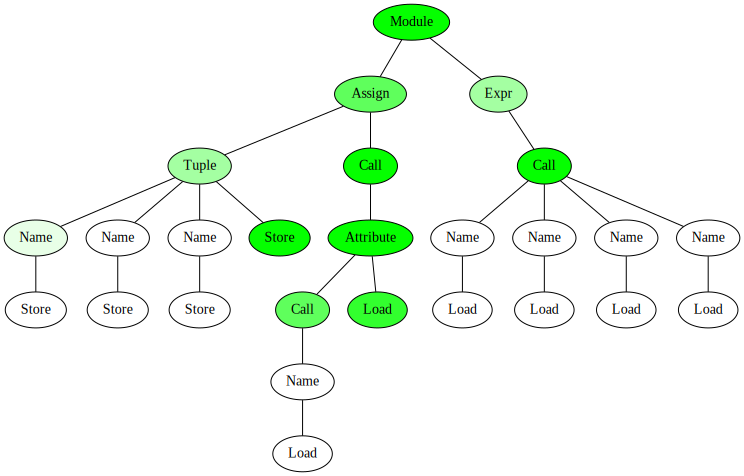

In [97]:
from collections import Counter
from visualization.GraphvizVisualizer import GraphvizVisualizer

conv_filter_activations = model.conv_layer(test_generator.__getitem__(test_file_id)[0])
node_importance = model.pooling_layer(conv_filter_activations)[0]
node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)
import pickle
with open(test_files[test_file_id], 'rb') as f:
    test_sample_ast = pickle.load(f)
vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)

## Analysis

In [23]:
problem_metadata = code_net.get_problem_metadata()

In [24]:
problem_ids = list(classification_dataset.get_labels())

In [28]:
problem_metadata.query(f"id in {problem_ids}")

,id,name,dataset,time_limit,memory_limit,rating,tags,complexity
2717,p02717,AtCoder Beginner Contest 161 - ABC Swap,AtCoder,2000,1048576,<NA>,<NA>,<NA>
2718,p02718,AtCoder Beginner Contest 161 - Popular Vote,AtCoder,2000,1048576,<NA>,<NA>,<NA>
2719,p02719,AtCoder Beginner Contest 161 - Replacing Integer,AtCoder,2000,1048576,<NA>,<NA>,<NA>
2723,p02723,AtCoder Beginner Contest 160 - Coffee,AtCoder,2000,1048576,<NA>,<NA>,<NA>
2724,p02724,AtCoder Beginner Contest 160 - Golden Coins,AtCoder,2000,1048576,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...
3494,p03494,AtCoder Beginner Contest 081 - Shift only,AtCoder,2000,262144,<NA>,<NA>,<NA>
3545,p03545,AtCoder Beginner Contest 079 - Train Ticket,AtCoder,2000,262144,<NA>,<NA>,<NA>
3835,p03835,AtCoder Beginner Contest 051 - Sum of Three In...,AtCoder,2000,262144,<NA>,<NA>,<NA>
4043,p04043,AtCoder Beginner Contest 042 - Iroha and Haiku...,AtCoder,2000,262144,<NA>,<NA>,<NA>


In [26]:
problem_metadata.query(f"id == 'p02859'")

,id,name,dataset,time_limit,memory_limit,rating,tags,complexity
2859,p02859,AtCoder Beginner Contest 145 - Circle,AtCoder,2000,1048576,<NA>,<NA>,<NA>


In [27]:
problem_metadata.query(f"id == 'p02915'")

,id,name,dataset,time_limit,memory_limit,rating,tags,complexity
2915,p02915,AtCoder Beginner Contest 140 - Password,AtCoder,2000,1048576,<NA>,<NA>,<NA>


In [21]:
classification_dataset.get_test_df().query("problem_id == 'p02859'")

,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy,count
12000,s481304996,p02859,u588829932,1573956105,Python,Python (3.4.3),py,Accepted,17,2940,27,<NA>,3216
12001,s883084144,p02859,u172785970,1574205675,Python,Python (3.4.3),py,Accepted,17,2940,26,<NA>,3216
12002,s146944190,p02859,u213401801,1573956361,Python,Python (3.4.3),py,Accepted,17,2940,25,<NA>,3216
12003,s159705607,p02859,u477977638,1573956069,Python,Python (3.4.3),py,Accepted,17,2940,930,<NA>,3216
12004,s755591562,p02859,u645538982,1573956117,Python,Python (3.4.3),py,Accepted,17,2940,26,<NA>,3216
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,s792237566,p02859,u660571124,1573956104,Python,Python (3.4.3),py,Accepted,17,2940,35,<NA>,3216
12296,s829563648,p02859,u000698877,1589169722,Python,Python (3.4.3),py,Accepted,17,2940,27,<NA>,3216
12297,s224637720,p02859,u166114774,1574480835,Python,Python (3.4.3),py,Accepted,17,2940,29,<NA>,3216
12298,s608033980,p02859,u463602788,1592472763,Python,Python (3.4.3),py,Accepted,17,2940,22,<NA>,3216
